### References:
* https://www.kaggle.com/maxwell110/beginner-s-guide-to-audio-data-2
* https://www.kaggle.com/daisukelab/cnn-2d-basic-solution-powered-by-fast-ai
* https://www.kaggle.com/christofhenkel/keras-baseline-lstm-attention-5-fold
* https://yerevann.github.io/2016/06/26/combining-cnn-and-rnn-for-spoken-language-identification/

### In this kernel, only train curated will be used.

I'm taking 5 seconds of spectrograms for each video -> likely an overkill, to be fine-tuned later.

To use the noisy set for training, a data generator is required, as the complete spectograms won't fit into the memory.


In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import librosa
import matplotlib.pyplot as plt
import gc

from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split

tqdm.pandas()

In [2]:
def calculate_overall_lwlrap_sklearn(truth, scores):
    """Calculate the overall lwlrap using sklearn.metrics.lrap."""
    # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap

In [3]:
def split_and_label(rows_labels):
    
    row_labels_list = []
    for row in rows_labels:
        row_labels = row.split(',')
        labels_array = np.zeros((80))
        
        for label in row_labels:
            index = label_mapping[label]
            labels_array[index] = 1
        
        row_labels_list.append(labels_array)
    
    return row_labels_list

In [4]:
train_curated = pd.read_csv('../input/train_curated.csv')
train_noisy = pd.read_csv('../input/train_noisy.csv')
test = pd.read_csv('../input/sample_submission.csv')

In [5]:
print(train_curated.shape, train_noisy.shape, test.shape)

(4970, 2) (19815, 2) (1120, 81)


In [6]:
label_columns = test.columns[1:]

In [7]:
label_mapping = dict((label, index) for index, label in enumerate(label_columns))

In [8]:
label_mapping

{'Accelerating_and_revving_and_vroom': 0,
 'Accordion': 1,
 'Acoustic_guitar': 2,
 'Applause': 3,
 'Bark': 4,
 'Bass_drum': 5,
 'Bass_guitar': 6,
 'Bathtub_(filling_or_washing)': 7,
 'Bicycle_bell': 8,
 'Burping_and_eructation': 9,
 'Bus': 10,
 'Buzz': 11,
 'Car_passing_by': 12,
 'Cheering': 13,
 'Chewing_and_mastication': 14,
 'Child_speech_and_kid_speaking': 15,
 'Chink_and_clink': 16,
 'Chirp_and_tweet': 17,
 'Church_bell': 18,
 'Clapping': 19,
 'Computer_keyboard': 20,
 'Crackle': 21,
 'Cricket': 22,
 'Crowd': 23,
 'Cupboard_open_or_close': 24,
 'Cutlery_and_silverware': 25,
 'Dishes_and_pots_and_pans': 26,
 'Drawer_open_or_close': 27,
 'Drip': 28,
 'Electric_guitar': 29,
 'Fart': 30,
 'Female_singing': 31,
 'Female_speech_and_woman_speaking': 32,
 'Fill_(with_liquid)': 33,
 'Finger_snapping': 34,
 'Frying_(food)': 35,
 'Gasp': 36,
 'Glockenspiel': 37,
 'Gong': 38,
 'Gurgling': 39,
 'Harmonica': 40,
 'Hi-hat': 41,
 'Hiss': 42,
 'Keys_jangling': 43,
 'Knock': 44,
 'Male_singing': 45

In [9]:
for col in tqdm(label_columns):
    train_curated[col] = 0
    train_noisy[col] = 0
    
print(train_curated.shape, train_noisy.shape)

100%|██████████| 80/80 [00:00<00:00, 1054.05it/s]

(4970, 82) (19815, 82)


In [11]:
train_curated_labels = split_and_label(train_curated['labels'])
train_noisy_labels = split_and_label(train_noisy['labels'])

In [12]:
train_curated[label_columns] = train_curated_labels
train_noisy[label_columns] = train_noisy_labels

In [13]:
train_curated['num_labels'] = train_curated[label_columns].sum(axis=1)
train_noisy['num_labels'] = train_noisy[label_columns].sum(axis=1)

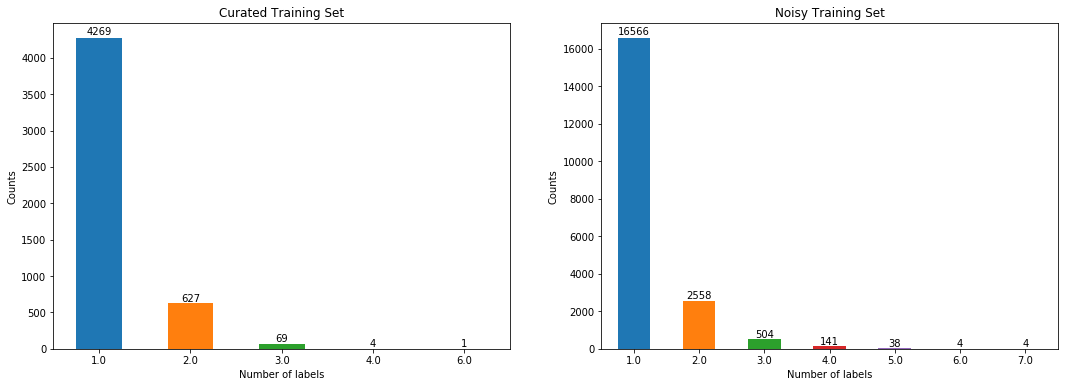

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(121)
ax1 = train_curated['num_labels'].value_counts().plot(kind='bar')
plt.xlabel('Number of labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.title('Curated Training Set')

for p in ax1.patches:
    ax1.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height() * 1.005), 
                ha='center',
                va='center',
                xytext=(0,5), 
                textcoords='offset points')

plt.subplot(122)
ax2 = train_noisy['num_labels'].value_counts().sort_index().plot(kind='bar', )
plt.xlabel('Number of labels')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.title('Noisy Training Set')

for p in ax2.patches:
    ax2.annotate(str(p.get_height()), 
                (p.get_x() + p.get_width()/2., p.get_height() * 1.005), 
                ha='center',
                va='center',
                xytext=(0,5), 
                textcoords='offset points')

    
plt.show()

In [15]:
# Special thanks to https://github.com/makinacorpus/easydict/blob/master/easydict/__init__.py

class EasyDict(dict):

    def __init__(self, d=None, **kwargs):
        if d is None:
            d = {}
        if kwargs:
            d.update(**kwargs)
        for k, v in d.items():
            setattr(self, k, v)
        # Class attributes
        for k in self.__class__.__dict__.keys():
            if not (k.startswith('__') and k.endswith('__')) and not k in ('update', 'pop'):
                setattr(self, k, getattr(self, k))

    def __setattr__(self, name, value):
        if isinstance(value, (list, tuple)):
            value = [self.__class__(x)
                     if isinstance(x, dict) else x for x in value]
        elif isinstance(value, dict) and not isinstance(value, self.__class__):
            value = self.__class__(value)
        super(EasyDict, self).__setattr__(name, value)
        super(EasyDict, self).__setitem__(name, value)

    __setitem__ = __setattr__

    def update(self, e=None, **f):
        d = e or dict()
        d.update(f)
        for k in d:
            setattr(self, k, d[k])

    def pop(self, k, d=None):
        delattr(self, k)
        return super(EasyDict, self).pop(k, d)

In [16]:
conf = EasyDict()
conf.sampling_rate = 44100
conf.duration = 5
conf.hop_length = 347 # to make time steps 128
conf.fmin = 20
conf.fmax = conf.sampling_rate // 2
conf.n_mels = 128
conf.n_fft = conf.n_mels * 20

conf.samples = conf.sampling_rate * conf.duration

train_curated_path = '../input/train_curated/'
train_noisy_path = '../input/train_noisy/'
test_path = '../input/test/'

In [17]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels

def convert_wav_to_image(df, source):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        try:
            x = read_as_melspectrogram(conf, f'{source[0]}/{str(row.fname)}', trim_long_data=True)
        except:
            x = read_as_melspectrogram(conf, f'{source[1]}/{str(row.fname)}', trim_long_data=True)

        #x_color = mono_to_color(x)
        X.append(x.transpose())
        #df.loc[i, 'length'] = x.shape[1]
    return X

In [18]:
#For baseline, noisy set is not used.
#train = pd.concat([train_curated, train_noisy],axis=0)

In [19]:
#del train_curated, train_noisy

#gc.collect()

In [20]:
%%time

#X = np.array(convert_wav_to_image(train, source=[train_curated_path, train_noisy_path]))
X = np.array(convert_wav_to_image(train_curated, source=[train_curated_path]))


CPU times: user 6min 13s, sys: 4min 30s, total: 10min 43s
Wall time: 5min 42s


In [21]:
Y = train_curated[label_columns].values

In [22]:
#del train
#gc.collect()

In [23]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Embedding, Input, Dense, CuDNNGRU,concatenate, Bidirectional, SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [24]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [25]:
sequence_input = Input(shape=(636,128), dtype='float32')
x = CuDNNGRU(128, return_sequences=True)(sequence_input) 
att = Attention(636)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x) 

x = concatenate([att, avg_pool, max_pool])

preds = Dense(80, activation='softmax')(x)

model = Model(sequence_input, preds)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 636, 128)     0                                            
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 636, 128)     99072       input_1[0][0]                    
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 128)          764         cu_dnngru_1[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 128)          0           cu_dnngru_1[0][0]                
_____________________________________

In [26]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.005),metrics=['acc'])

In [28]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=123)

In [29]:
del X, Y
gc.collect()

10

In [30]:
assert len(x_train) == len(y_train)
assert len(x_val) == len(y_val)

In [31]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=3)

In [32]:
model.fit(np.array(x_train),
          y_train,
          batch_size=1024,
          epochs=100,
          validation_data=(np.array(x_val), y_val),
          callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 3976 samples, validate on 994 samples
Epoch 1/100
3976/3976 [==============================] - 5s 1ms/step - loss: 5.3089 - acc: 0.0236 - val_loss: 4.9422 - val_acc: 0.0412
Epoch 2/100
3976/3976 [==============================] - 3s 753us/step - loss: 4.8055 - acc: 0.0604 - val_loss: 4.6250 - val_acc: 0.0905
Epoch 3/100
3976/3976 [==============================] - 3s 750us/step - loss: 4.4840 - acc: 0.1016 - val_loss: 4.4143 - val_acc: 0.0845
Epoch 4/100
3976/3976 [==============================] - 3s 762us/step - loss: 4.2439 - acc: 0.1426 - val_loss: 4.2101 - val_acc: 0.1519
Epoch 5/100
3976/3976 [==============================] - 3s 757us/step - loss: 4.0277 - acc: 0.1793 - val_loss: 4.0830 - val_acc: 0.1348
Epoch 6/100
3976/3976 [==============================] - 3s 762us/step - loss: 3.8401 - acc: 0.1939 - val_loss: 3.9440 - val_acc: 0.1821
Epoch 7

In [33]:
y_train_pred = model.predict(np.array(x_train))
y_val_pred = model.predict(np.array(x_val))

In [34]:
train_lwlrap = calculate_overall_lwlrap_sklearn(y_train, y_train_pred)
val_lwlrap = calculate_overall_lwlrap_sklearn(y_val, y_val_pred)

print(f'Training LWLRAP : {train_lwlrap:.4f}')
print(f'Validation LWLRAP : {val_lwlrap:.4f}')

Training LWLRAP : 0.6781
Validation LWLRAP : 0.4999


In [35]:
%%time
X_test = np.array(convert_wav_to_image(test, source=[test_path]))


CPU times: user 1min 27s, sys: 1min 3s, total: 2min 30s
Wall time: 1min 20s


In [36]:
predictions = model.predict(np.array(X_test))

In [37]:
test[label_columns] = predictions

In [38]:
test.to_csv('submission.csv', index=False)